In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl


In [2]:
import torch
torch.manual_seed(12)
import random
random.seed(12)
import numpy as np
np.random.seed(12)

In [3]:
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
import pickle
with open("/kaggle/input/ml-assignment-cl-ii-lab-task2-part1/euroSAT_train_val_test.pkl", "rb") as f:
    train_set, val_set, test_set = pickle.load(f)
print(len(train_set), len(val_set),  len(test_set))
print(train_set[0][0].shape, train_set[0][1])

18792 2808 5400
(3, 64, 64) 7


In [5]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
val_dataloader = DataLoader(val_set)

In [6]:
label_to_class_mapping = {
    0 : "AnnualCrop",
    1 : "Forest",
    2 : "HerbaceousVegetation",
    3 : "Highway",
    4 : "Industrial",
    5 : "Pasture",
    6 : "PermanentCrop",
    7 : "Residential",
    8 : "River",
    9 : "SeaLake"
}

Feature batch shape: torch.Size([64, 3, 64, 64])
Labels batch shape: torch.Size([64])


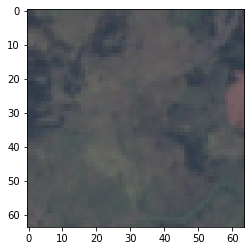

Label: HerbaceousVegetation


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
# img.permute : C * W * H -> W * H * C
plt.imshow(img.permute(1,2, 0), cmap="gray")
plt.show()
print(f"Label: {label_to_class_mapping[label.item()]}")

In [8]:
import torchvision.models as models

In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [10]:
class MyResnet(nn.Module):
    def __init__(self, num_classes=10):
        super(MyResnet, self).__init__()
        self.network = models.resnet18(pretrained=True)
#         for param in self.network.parameters():
#             param.requires_grad = False
        
        self.network.fc = nn.Linear(in_features=512, out_features=num_classes) 
        
    def forward(self, x):
        x = self.network(x)
        return x

In [11]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = MyResnet(num_classes=10).to(device)

print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

MyResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [12]:
# c, d = 0, 0
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         c += 1
#         print(name, param)
#     else:
#         d += 1
# c,d

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    correct = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Calculate the accuracy for this batch
        _, predicted = torch.max(output.data, 1)
        correct += torch.sum(target==predicted).item()

        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
#         print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    acc = 100. * correct / len(train_loader.dataset)
    print('Training set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
        avg_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return avg_loss, acc

In [14]:
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    acc = 100. * correct / len(test_loader.dataset)
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss, acc

In [15]:
import os
os.makedirs("logs_resnet", exist_ok=True)

In [16]:
# Create an instance of the model class and allocate it to the device
model = MyResnet(num_classes=10).to(device)

# print(model)

# Use an "Adam" optimizer to adjust weights
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []

epochs = 20 
k = 20 # patience
up = 0

min_validation_loss = float('inf')
best_model_path = "logs_resnet/best_model.pth"

print(f'Training on', device)
for epoch in range(1, epochs + 1):
        train_loss, train_acc = train(model, device, train_dataloader, optimizer, epoch)
        val_loss, val_acc = test(model, device, val_dataloader)

        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        training_accuracy.append(train_acc)
        validation_accuracy.append(val_acc)

        if val_loss < min_validation_loss:
            min_validation_loss = val_loss
            torch.save(model, best_model_path)
            print(f"Found best model at valiation loss = {min_validation_loss}\n")
        
        if epoch >= k:
            # if validation loss does not improve over last k epochs (patience) stop
            if val_loss >= validation_loss[-2]:
                up += 1
            else:
                up = 0

            if up == k:
                # early stopping
                print(f"Early Stopping Training: Validation Loss = {val_loss}")
                break

Training on cuda
Epoch: 1
Training set: Average loss: 0.343280, Accuracy: 16752/18792 (89%)
Validation set: Average loss: 0.136521, Accuracy: 2692/2808 (96%)

Found best model at valiation loss = 0.13652078640656695

Epoch: 2
Training set: Average loss: 0.086430, Accuracy: 18273/18792 (97%)
Validation set: Average loss: 0.130393, Accuracy: 2694/2808 (96%)

Found best model at valiation loss = 0.13039280217734553

Epoch: 3
Training set: Average loss: 0.044961, Accuracy: 18500/18792 (98%)
Validation set: Average loss: 0.136965, Accuracy: 2697/2808 (96%)

Epoch: 4
Training set: Average loss: 0.038981, Accuracy: 18570/18792 (99%)
Validation set: Average loss: 0.120425, Accuracy: 2705/2808 (96%)

Found best model at valiation loss = 0.12042451465579965

Epoch: 5
Training set: Average loss: 0.027470, Accuracy: 18630/18792 (99%)
Validation set: Average loss: 0.125060, Accuracy: 2719/2808 (97%)

Epoch: 6
Training set: Average loss: 0.023787, Accuracy: 18646/18792 (99%)
Validation set: Average 

# Saving and Loading Best Model

## Loading Best Model from Google Drive

Run this section only if you want to download the best weight model from google drive into Kaggle VM

In [17]:
!pip install gdown

import gdown
from shutil import unpack_archive
id = "1ZgdqcGyUFATKelU_jdX2YXh6oTx7Tyhw"

zip_file_name = "CL2_Assignment_8_Task_2_Part_1.zip"
extract_directory_name = "CL2_Assignment_8_Task_2_Part_1_Weights"

gdown.download(id=id, output=zip_file_name)
unpack_archive(zip_file_name, extract_directory_name)

import os
os.remove(zip_file_name)

best_model_path = extract_directory_name + "/" + "logs_resnet" + "/" + "best_model.pth"
best_model = torch.load(best_model_path)

  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - \ | / - done
  Preparing metadata (pyproject.toml) ... - \ | / - done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14775 sha256=32929e67eb4e2dbf31766699859a7f9e4621dc5cd355e5ed47b8a064749f1964
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown


Downloading...
From: https://drive.google.com/uc?id=1ZgdqcGyUFATKelU_jdX2YXh6oTx7Tyhw
To: /kaggle/working/CL2_Assignment_8_Task_2_Part_1.zip
100%|██████████| 41.8M/41.8M [00:01<00:00, 28.9MB/s]


## Load model from Kaggle VM (current best model)

Run this code if you want to load current best model (not Google Drive Model)

In [18]:
torch.save(model, best_model_path)
best_model = torch.load(best_model_path)

# Reporting Accuracy on Validation Data

In [19]:
classes = list(label_to_class_mapping.values())
truelabels = []
predictions = []
best_model.eval()
c, t = 0, 0
print("Getting predictions from val set...")
with torch.no_grad():
    for data, target in val_dataloader:
        data = data.to(device)
        for label in target.data.numpy():
            truelabels.append(label)
        for prediction in best_model(data).cpu().data.numpy().argmax(1):
            predictions.append(prediction)

for i in range(len(truelabels)):
    if predictions[i] == truelabels[i]:
        c += 1
    t += 1

print(f"Accuracy on validation data {c*100/t}")

Getting predictions from val set...
Accuracy on validation data 96.47435897435898


# Reporting accuracy on Test Data

In [20]:
classes = list(label_to_class_mapping.values())
truelabels = []
predictions = []
best_model.eval()
c, t = 0, 0
print("Getting predictions from test set...")
with torch.no_grad():
    for data, target in test_dataloader:
        data = data.to(device)
        for label in target.data.numpy():
            truelabels.append(label)
        for prediction in best_model(data).cpu().data.numpy().argmax(1):
            predictions.append(prediction)

for i in range(len(truelabels)):
    if predictions[i] == truelabels[i]:
        c += 1
    t += 1
print(f"Accuracy on test data {c*100/t}")

with open("predictions.csv", "w") as f:
    print("id,label", file=f)
    for i in range(len(truelabels)):
        print(f"{i},{predictions[i]}", file=f)

Getting predictions from test set...
Accuracy on test data 96.92592592592592


Getting predictions from test set...


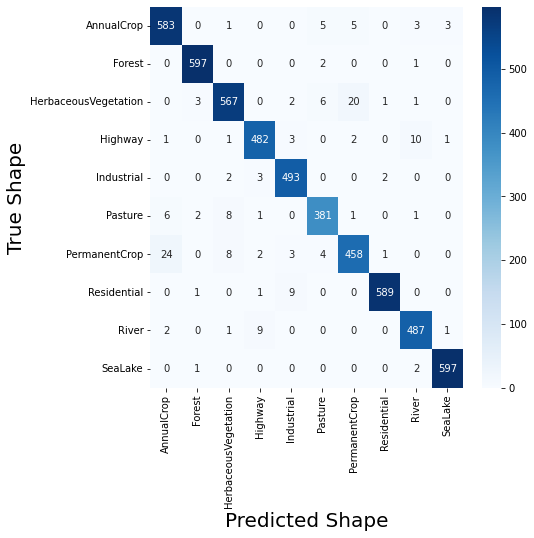

In [21]:
classes = list(label_to_class_mapping.values())
truelabels = []
predictions = []
best_model.eval()
print("Getting predictions from test set...")
with torch.no_grad():
    for data, target in test_dataloader:
        data = data.to(device)
        for label in target.data.numpy():
            truelabels.append(label)
        for prediction in best_model(data).cpu().data.numpy().argmax(1):
            predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
tick_marks = np.arange(len(classes))
                       
df_cm = pd.DataFrame(cm, index = classes, columns = classes)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()

# Recall for each class

In [22]:
from sklearn.metrics import classification_report
report = classification_report(truelabels, predictions, target_names=classes,output_dict=True)

for class_label in classes:
    print(f"Recall for {class_label} is {report[class_label]['recall']}")

Recall for AnnualCrop is 0.9716666666666667
Recall for Forest is 0.995
Recall for HerbaceousVegetation is 0.945
Recall for Highway is 0.964
Recall for Industrial is 0.986
Recall for Pasture is 0.9525
Recall for PermanentCrop is 0.916
Recall for Residential is 0.9816666666666667
Recall for River is 0.974
Recall for SeaLake is 0.995


## Plot of Accuracy and Loss for Trainining and Validation Sets

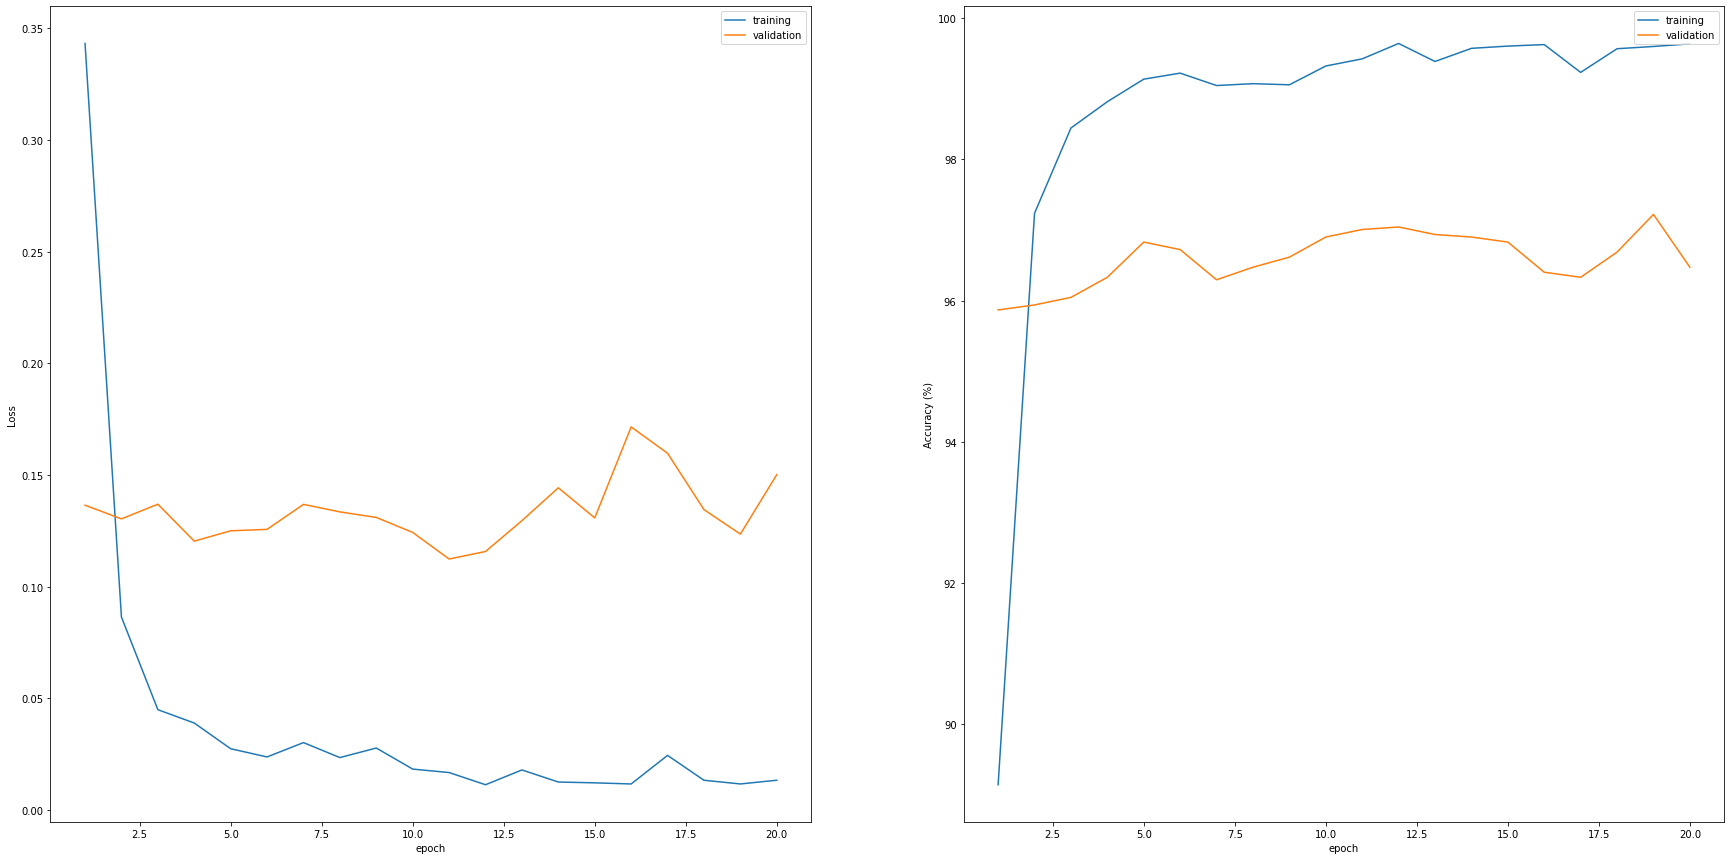

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

ax1.plot(epoch_nums, training_loss)
ax1.plot(epoch_nums, validation_loss)
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
ax1.legend(['training', 'validation'], loc='upper right')

ax2.plot(epoch_nums, training_accuracy)
ax2.plot(epoch_nums, validation_accuracy)
ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend(['training', 'validation'], loc='upper right')


plt.show()